# Computer Vision - Maman 1
imports

In [316]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from LoG_filter import log_filt

Constants

In [317]:
MEAN = 10 # q1-a - Mean
SD = 5 # q1-a - Standard deviation
SIZE = (100, 100) # q1-a - Size of matrix

Halper Functions

In [318]:
''' Show image in grayscale
'''
def show_gray_image(image):
    plt.imshow(image, cmap='gray')

In [319]:
''' Show image in color
''' 
def show_color_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [320]:
'''  Load image from file 
'''
def load_image(file_name):
    return cv2.imread(file_name, cv2.IMREAD_UNCHANGED)

In [321]:
''' Convert image to grayscale
'''
def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


### Question 1

#### <ins>Q1.a </ins>

In [322]:
''' ranged gaussian helper function - to limit the matrix to spesific range
'''
def ranged_gausian(matrix, min_value, max_value):
    return min_value + (max_value - min_value) * (matrix - matrix.min()) / (matrix.max() - matrix.min())

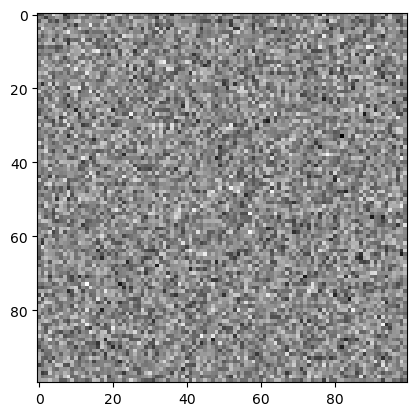

In [323]:
# Create gaussian distribution matrix
matrix = np.array(np.random.normal(MEAN, SD, SIZE))
# Limit the matrix to spesific range
output_matrix = ranged_gausian(matrix, min_value=0, max_value=255)
# Convert to uint8, to show as image later
output = output_matrix.astype(np.uint8)
# Show the image
show_gray_image(output)

#### <ins>Q1.b </ins>

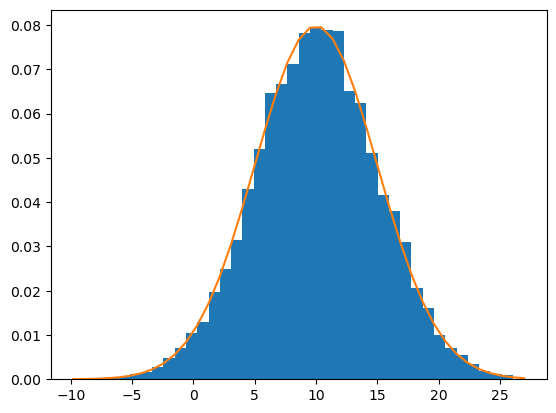

In [324]:
# Flatten the matrix, and then draw the hostogram 
n, bins, ignored = plt.hist(matrix.flatten(), bins=40, density=True)
# draw the distribution function to compare with
plt.plot(bins, np.exp(-pow(bins - MEAN, 2) / (2 * pow(SD, 2))) / (SD * np.sqrt(2 * np.pi)))
#show the plot
plt.show()

#### <ins>Q1.c </ins>

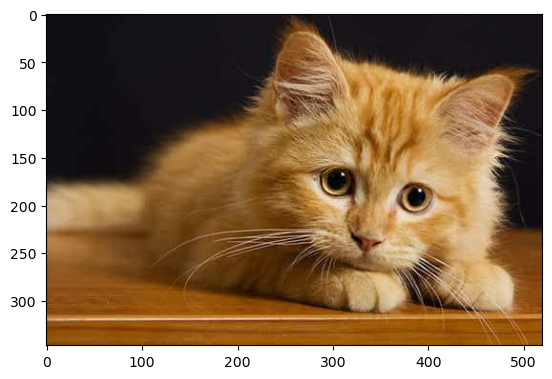

In [325]:
# image is loaded with imread command
file_name = 'cat.JPG'
image = load_image(file_name)
show_color_image(image)

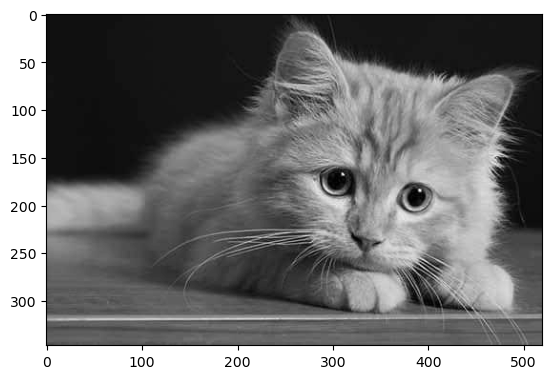

In [326]:
# convert the input image into grayscale color space
gray_image = convert_to_gray(image)
# Show image in gray
show_gray_image(gray_image)

#### <ins>Q1.d </ins>

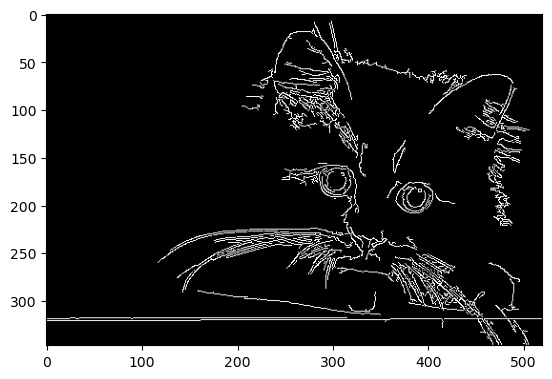

In [327]:
show_gray_image(cv2.Canny(image, 100, 350))

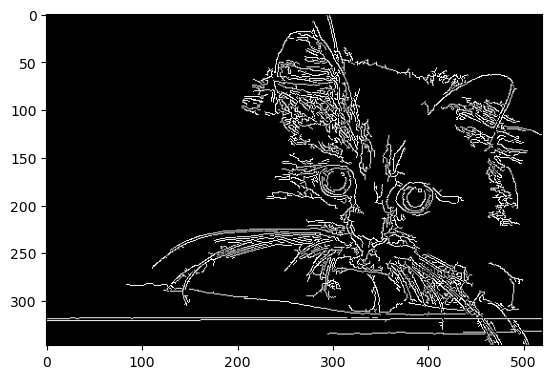

In [328]:
show_gray_image(cv2.Canny(image, 50, 300))

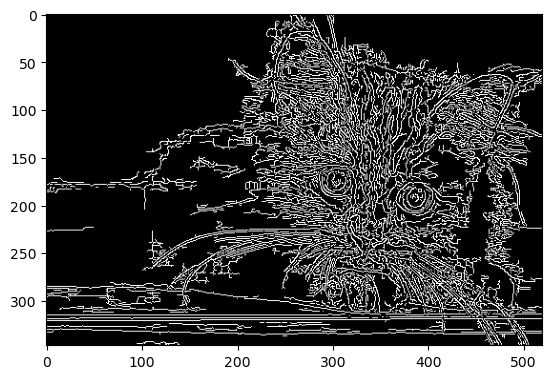

In [329]:
show_gray_image(cv2.Canny(image, 10, 100))

#### <ins>Q1.E </ins>

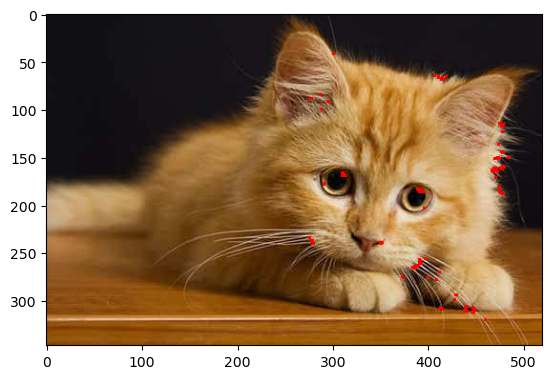

In [330]:
def add_harris_points(image, gray_image, blockSize, ksize, k):
    # modify the data type to 32-bit floating point
    operatedImage = np.float32(gray_image)
    
    # apply the cv2.cornerHarris method to detect the corners
    dest = cv2.cornerHarris(operatedImage, blockSize, ksize, k)
    
    # Results are marked through the dilated corners
    dest = cv2.dilate(dest, None)

    # Reverting back to the original image with optimal threshold value
    image[dest > 0.01 * dest.max()]=[0, 0, 255]
    
    # the window showing output image with corners
    show_color_image(image)

add_harris_points(image, gray_image, 2, 3, 0.08)

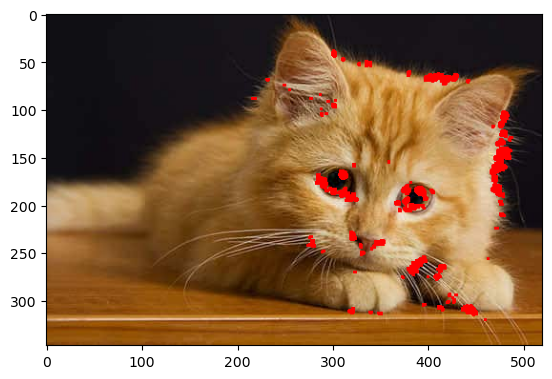

In [331]:
add_harris_points(image, gray_image, 4, 9, 0.01)

### Question 2

Consts

In [332]:
# The const value for sigma generation
k = 2 ** 0.25
# The initiall sigma
sigma = 2
# Numbers of layers in the pyramid
n = 15
# The filenames of the pictures to process
file_name_butterfly = 'butterfly.jpg'
file_name_einstein = 'einstein.jpg'
file_name_fishes = 'fishes.jpg'
file_name_sunflowers = 'sunflowers.jpg'
file_name_candy='candy.jpg'
file_name_cat2 = 'cat2.jpg'
# 3D window size
window_length = 3
window_depth = 10

Halpers

In [333]:
''' Returns both color and grayscale loaded version of given file
'''
def load_image_color_gray(file_name: str):
    image_color = load_image(file_name)
    image_gray = convert_to_gray(image_color)
    return image_color, image_gray

In [334]:
''' Convert simple array to np
'''
def convert_to_np_arr(array):
    return np.array([i for i in array])

### <ins>Q2.1</ins>

In [335]:
# Load color and grayscale loaded version of given file
image_color, image_gray = load_image_color_gray(file_name_butterfly)
# image normalization
image_gray = image_gray/255.0  

In [336]:
''' Calculate LoG pyramid 
@img - the image
@n - Number of layers to create
@k - The constant to multiply sigma by
@sigma - The initial sigma
'''
def create_LoG_pyramid(img, n, k, sigma):
    #to store responses
    LoG_pyramid = []
    # initiallize current sigma var
    curr_sigam = sigma
    for i in range(0, n):
        # Sigma is multiplied by K evey step
        curr_sigam *= k 
        # Calculate filter size by the given function
        filter_size = 2 * np.ceil(3 * curr_sigam) + 1
        # Genarate the filter with the given filter function and then nurmallize
        filter_LoG = log_filt(filter_size, curr_sigam) * (curr_sigam ** 2) 
        # Convolve the image with the filter
        image = cv2.filter2D(img, cv2.CV_64F, filter_LoG) 
        # Add the cretaed image to the pyramid
        LoG_pyramid.append(image)
    # Store the pyramid in a numpy array
    LoG_pyramid_np = convert_to_np_arr(LoG_pyramid)
    return LoG_pyramid_np

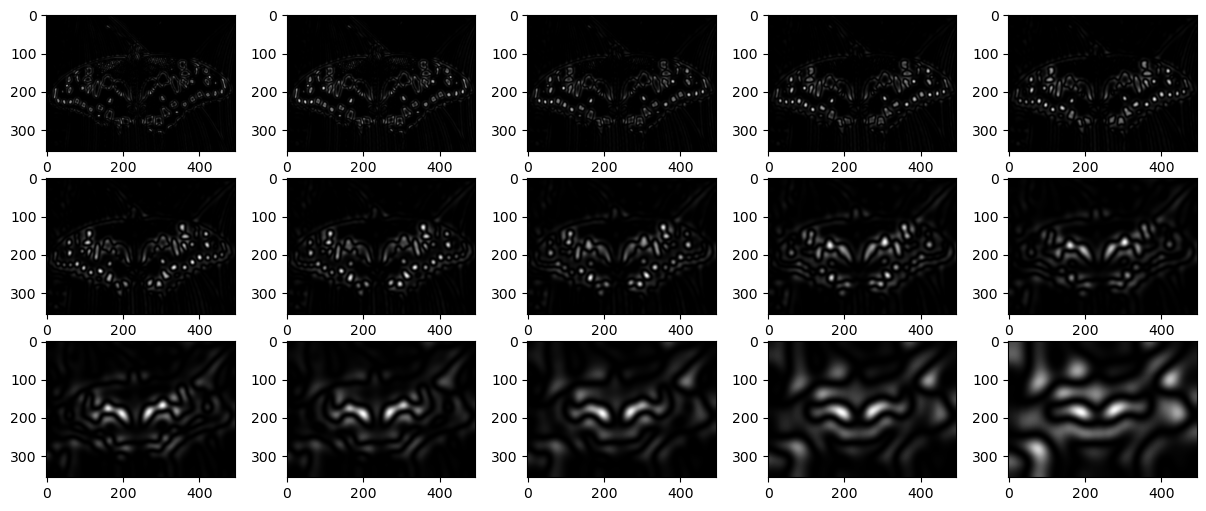

In [337]:
# Create a figure to show the pyramid on
fig = plt.figure(figsize=(15, 6))
# Create the pyramid
LoG_pyramid_np = create_LoG_pyramid(image_gray, n, k, sigma)
for i in range(1, n+1):
    # Calculate element-wise square
    LoG_pyramid_np[i-1] = np.square(LoG_pyramid_np[i-1])
    # Put the result image in the figure suitable cell
    fig.add_subplot(3, 5, i)
    # Draw the image
    show_gray_image(LoG_pyramid_np[i-1])
# Show the figure
plt.show(block=True)

### <ins>Q2.2</ins>

In [347]:
''' Non-maximum supression - Finds local maximums in the 3D array
@img - the image
@log_pyramid - The LoG pyramid we calculated
@window - Size of the desired window
@sigma, @k - params for the algorithm
@threshold - the threshold for the blobs - 0.03 by default
'''
def maximaDetection(image, LoG_pyramid, window, depth, sigma, k, threshold=0.05):
    # Calculate half window size
    half_window = window // 2
    # Calculate half window size
    half_depth = depth // 2
    # Get the size of the imagee
    row, col = image.shape
    # Get the number of scales
    scales = LoG_pyramid.shape[0]
    # The output array of blobs
    blobs = []
    # pad the pyramid by half_window from all direction, to deal with the edges of the image
    LoG_pyramid = np.pad(LoG_pyramid, [(half_window,half_window),(half_window,half_window),(half_window,half_window)], mode='constant',constant_values=0)
    # Loop over scales
    for s in range(half_depth, scales+half_depth, half_depth):   
        # Loop over rows
        for i in range(half_window, row+half_window):
            # Loop over columns
            for j in range(half_window, col+half_window):                        
                    # Get a slice of the pyramid
                    slice_pyramid = LoG_pyramid[s-half_depth:s+half_depth+1, i-half_window:i+half_window+1,j-half_window:j+half_window+1]
                    # Geet the center pixel of the pyramid - the one we checking now
                    center_slice = slice_pyramid[:, half_window, half_window]
                    # Get the local maximum
                    result = np.amax(slice_pyramid)
                    # Check of the center pixel is the local maximum, and it's greater then the threshold
                    if result in center_slice and result>=threshold:
                        # Get the index axis
                        z, x, y = np.unravel_index(slice_pyramid.argmax(), slice_pyramid.shape)
                        # Calculate the blob x,y and the suitable sigma
                        blob_x = x+i-half_window-1
                        blob_y = y+j-half_window-1
                        sigma_curr = sigma*k**(z+s-half_depth-1)
                        radius = np.round(sigma_curr).astype("int")
                        # Add the blob to the output array
                        blobs.append((blob_x, blob_y, radius))
    return blobs

### <ins>Q2.3</ins>

In [348]:
''' Draw the blobs we found on the image
@image - The image to draw on
@blobs - The blobs we found
@thick - the thickness of circlrs to draw - optional
'''
def draw_blobs(image, blobs):
    # Make a copy of the image to draw on
    out_image = image.copy()
    for blob in blobs:
        # Create the circle in the place of the blob
        cv2.circle(img=out_image, center=(blob[1],blob[0]), radius=blob[2], color=(0,0,255))
    return out_image

Sum to Blob detector function

In [363]:
''' Detect the blobs by the steps we implemented before
@filename - The file name of the image to process
@thickn - The thickness of the circles to draw - optional
'''
def detect_blobs(filename, threshold=0.05):
    image_color, image_gray = load_image_color_gray(filename)
    LoG_image = create_LoG_pyramid(image_gray, n, k, sigma)
    blobs = maximaDetection(image_gray,LoG_image, window_length, window_depth, sigma, k, threshold)
    out_image = draw_blobs(image_color, blobs)
    show_color_image(out_image)

Try the detection aon different images

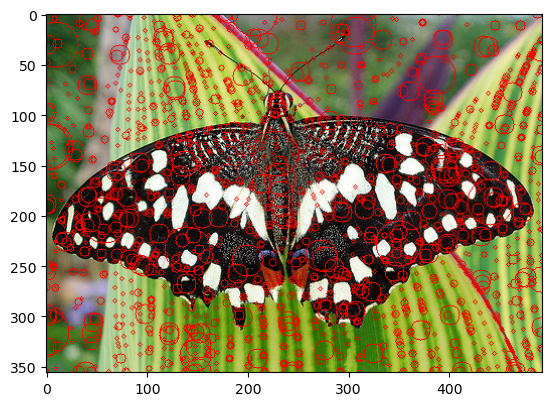

In [364]:
detect_blobs(file_name_butterfly, 1)

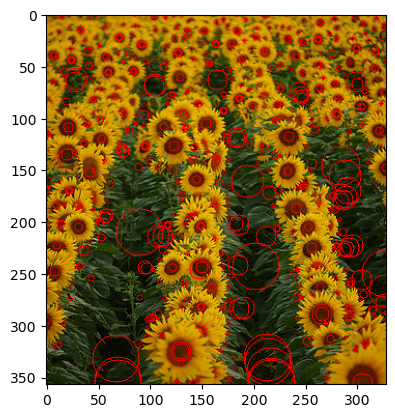

In [365]:
detect_blobs(file_name_sunflowers, 25)

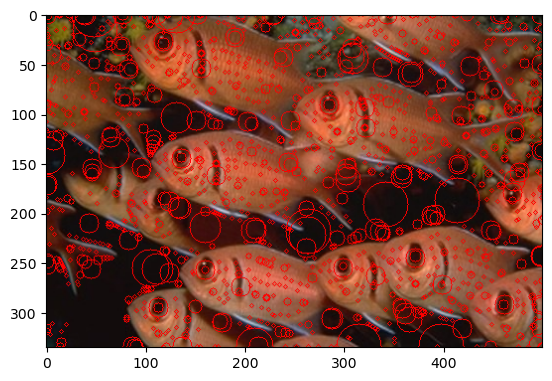

In [366]:
detect_blobs(file_name_fishes, 1)

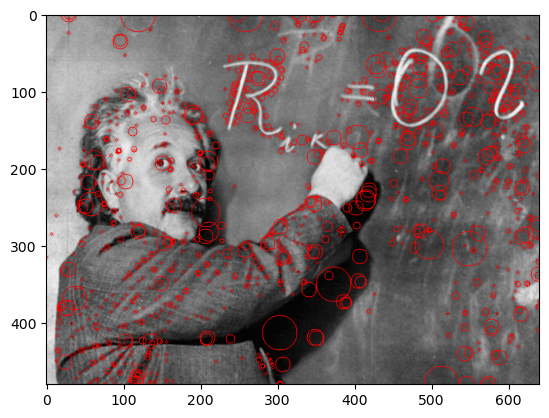

In [367]:
detect_blobs(file_name_einstein, threshold=10)

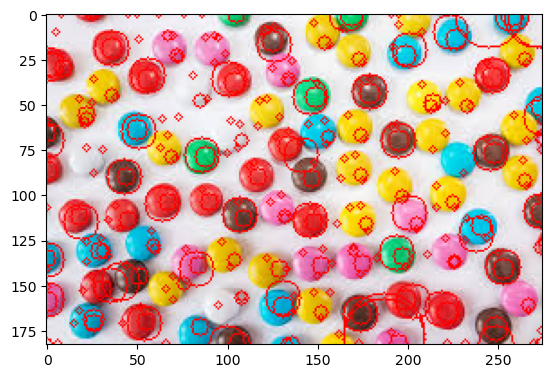

In [368]:
detect_blobs(file_name_candy, threshold=0.01)

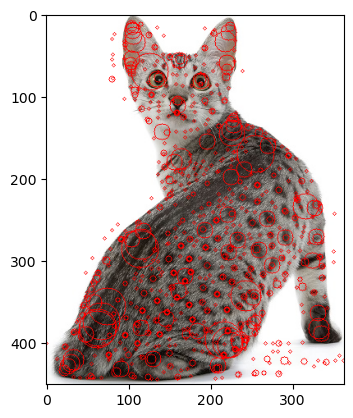

In [369]:

detect_blobs(file_name_cat2)